In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

In [9]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA

#tb.loc[tb['Instrument Classification (ISO 10962 CFI code)'].isin(['JFTXFP'])]
#tb.plot.hist(tb.groupby(['Trading platform']).Price.agg(['mean', max]))
#tb.describe()
#print(tb.shape)

#df = pd.read_feather('C:/Users/asus/Documents/rts27.feather')
df = pd.read_feather('C:/Users/inald/Documents/NWMprod/wetransfer-0f4d76/rts27.feather')

#Columns deemed unneccessary for this task
df2 = df.drop(['file_name','designated_market_makers','legal_entity_name', 'systematic_internaliser_flag'], axis = 1)


df2.head(10)

,id,bank_name,date_of_trading_day,instrument_identifier,instrument_classification,order_request_quotes_received,executed_transactions,total_value_of_transactions,order_request_quotes_can_wdrwn,order_request_quotes_modified,...,median_transaction_size_eur,median_transaction_size_gbp,median_size_request_quotes_eur,median_size_request_quotes_gbp,smartie_instrument_name,data_quality_flag,egb_eligible_flag,year_quarter,business,central_bank_isin_flag
0,77854033,UBS,2018-12-18,CH0386503236,None,0.0,1.0,20.000,0.0,0.0,...,20.000000,17.981601,NaN,NaN,None,Y,None,2018 Q4,None,None
1,77854248,UBS,2018-12-20,CH0386504416,None,0.0,2.0,400.000,0.0,0.0,...,200.000000,180.523989,NaN,NaN,None,Y,None,2018 Q4,None,None
2,77856619,UBS,2018-10-08,CH0394745357,None,0.0,1.0,100.000,0.0,0.0,...,100.000000,87.869988,NaN,NaN,None,Y,None,2018 Q4,None,None
3,77818775,UBS,2018-11-27,AN8068571086,None,0.0,2.0,3184.000,0.0,0.0,...,2723.487198,2413.062250,NaN,NaN,None,Y,None,2018 Q4,None,None
4,77818788,UBS,2018-10-31,AN8068571086,None,0.0,4.0,77641.000,0.0,0.0,...,963.780919,854.948672,NaN,NaN,None,Y,None,2018 Q4,None,None
5,78737782,UBS,2018-12-07,EZKDQ6DRGH95,None,0.0,1.0,8904.901,0.0,0.0,...,7816.011236,6983.529412,NaN,NaN,None,Y,None,2018 Q4,None,None
6,78738980,UBS,2018-11-19,EZKGZGMRWNG1,None,0.0,5.0,3598.310,0.0,0.0,...,268.972142,239.539586,NaN,NaN,None,Y,None,2018 Q4,None,None
7,78744698,UBS,2018-11-30,EZKSTQRK3284,None,0.0,2.0,3433.450,0.0,0.0,...,1770.474424,1570.163755,NaN,NaN,None,Y,None,2018 Q4,None,None
8,78744713,UBS,2018-12-21,EZKSVCDDP7S3,None,0.0,2.0,61202.440,0.0,0.0,...,33552.908199,30220.118343,NaN,NaN,None,Y,None,2018 Q4,None,None
9,78744728,UBS,2018-12-28,EZKSVJYKDXB9,None,0.0,1.0,6697.360,0.0,0.0,...,5852.486236,5276.552159,NaN,NaN,None,Y,None,2018 Q4,None,None


In [13]:
from datetime import date, timedelta  

df = df2
#Filters the code to FX forwards only
df = df.loc[(df['instrument_classification']).astype(str).str.contains("JF") | (df['source_instrument_desc']).astype(str).str.contains("Forward") | (df['source_instrument_name']).astype(str).str.contains("Forward")]
df = df.drop(['order_request_quotes_received', 'total_value_of_transactions', 'liquidity_provider_flag','executed_transactions', 'median_size_request_quotes_gbp','egb_eligible_flag','data_quality_flag','central_bank_isin_flag', 'data_quality_flag', 'smartie_instrument_name', 'active', 'business', 'order_request_quotes_can_wdrwn','order_request_quotes_modified'], axis = 1)

#df.to_csv('C:/Users/inald/Documents/NWMprod/wetransfer-0f4d76/RTS27filtered.csv')
print(df['bank_name'].unique())

#today = date.today()
#week_prior =  today - timedelta(weeks = 128)
#week_ahead =  today - timedelta(weeks = 132)
#df_last_week = df[(df['date_of_trading_day'] <= week_prior) and (df['date_of_trading_day'] >= week_ahead)]

#df_last_week


['Credit Suisse' 'Morgan Stanley' 'Deutsche Bank' 'HSBC' 'Goldman Sachs'
 'BAML' 'Societe Generale' 'Natwest Markets' 'Barclays' 'Nomura'
 'JPMorgan Chase' 'Citibank' 'UBS' 'BNP Paribas']


In [ ]:
df.to_csv('C:/Users/inald/Documents/NWMprod/wetransfer-0f4d76/RTS27filtered.csv')

In [14]:
reducedRTS = pd.read_csv("C:/Users/inald/Documents/NWMprod/wetransfer-0f4d76/RTS27filtered.csv")

['HSBC' 'Deutsche Bank' 'Goldman Sachs' 'BAML' 'Morgan Stanley'
 'Societe Generale' 'Barclays' 'JPMorgan Chase' 'Nomura' 'UBS']


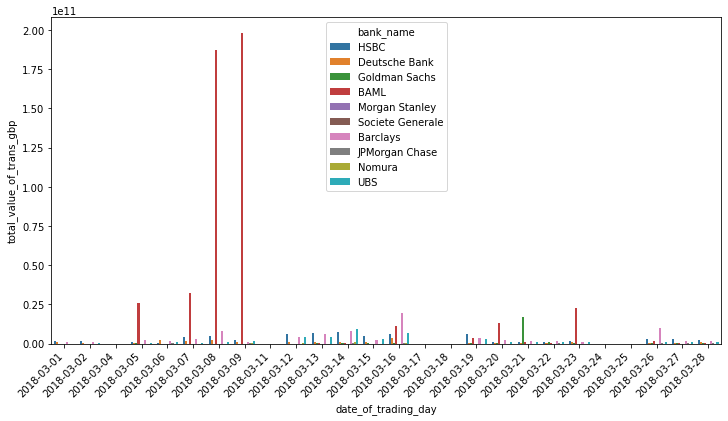

In [15]:

reducedRTS['date_of_trading_day'] = pd.to_datetime(reducedRTS['date_of_trading_day'])
start_date = '2018-02-28'
end_date = '2018-03-28'
mask = (reducedRTS['date_of_trading_day'] > start_date) & (reducedRTS['date_of_trading_day'] <= end_date) & ((reducedRTS['source_instrument_name']).astype(str).str.contains("20180620") | (reducedRTS['source_instrument_desc']).astype(str).str.contains("20180620"))



q1Rts = reducedRTS.loc[mask]
q1Rts

fig, ax = plt.subplots(figsize = (12,6))
sns.barplot(x = q1Rts['date_of_trading_day'], y = q1Rts['total_value_of_trans_gbp'], estimator = sum, ci = None ,ax=ax, hue = q1Rts['bank_name'])
x_dates = q1Rts['date_of_trading_day'] .dt.strftime('%Y-%m-%d').sort_values().unique()
ax.set_xticklabels(labels=x_dates, rotation=45, ha='right')
print(q1Rts['bank_name'].unique())

['Deutsche Bank' 'Goldman Sachs' 'Barclays' 'JPMorgan Chase' 'UBS']


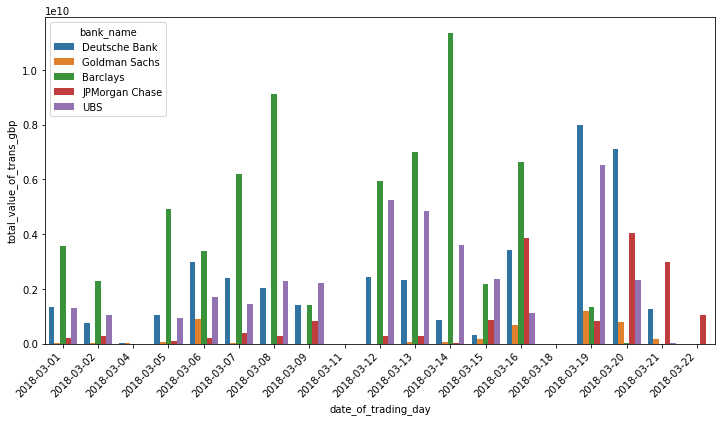

In [155]:
fig, ax = plt.subplots(figsize = (12,6))
sns.barplot(x = df['date_of_trading_day'], y = df['total_value_of_trans_gbp'], estimator = sum, ci = None ,ax=ax, hue = df['bank_name'])
x_dates = df['date_of_trading_day'] .dt.strftime('%Y-%m-%d').sort_values().unique()
ax.set_xticklabels(labels=x_dates, rotation=45, ha='right')
print(df['bank_name'].unique())

In [64]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
#from sklearn_pandas import DataFrameMapper

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn import datasets, linear_model
from sklearn.decomposition import TruncatedSVD


from datetime import datetime

#Columns deemed unneccessary for this task
#df = df.drop(['file_name','designated_market_makers','legal_entity_name', 'systematic_internaliser_flag'], axis = 1)


#Filters the code to FX forwards only
#df = df.loc[(df['source_instrument_desc']).astype(str).str.contains("Forward")]
df=df2
df = df.loc[(df['instrument_classification']).astype(str).str.contains("JF") | (df['source_instrument_desc']).astype(str).str.contains("Forward")]
#Drops the columns of which half of the fields have no data.
#df = df.dropna(axis=1, thresh=2000000)

        
# Select target
y = df['total_value_of_transactions']
# To keep things simple, we'll use only numerical predictors
dropped_df = df.drop(['total_value_of_transactions'], axis=1)
X = dropped_df

im = SimpleImputer(strategy='mean',missing_values=np.nan)
y = y.to_numpy().reshape(-1,1)
y = im.fit_transform(y)
y = pd.DataFrame(y)
print(y)

# Divide data into training and validation subsets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                      random_state=0)

categorical_cols = [col for col in X.columns if X[col].dtype in ['object']]

# Select numerical columns
numerical_cols = [col for col in X.columns if X[col].dtype in ['int64', 'float64']]
       
# Keep selected columns only
my_cols = categorical_cols + numerical_cols
X_train = X_train[my_cols].copy()
X_valid = X_valid[my_cols].copy()

numerical_transformer = SimpleImputer(strategy='mean',missing_values=np.nan)

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer',SimpleImputer(strategy='constant',missing_values=None, fill_value='missing_value')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

sc = StandardScaler()

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ], remainder='passthrough')

model = linear_model.LinearRegression()

#print(preprocessor.fit_transform(X_train, y_train))

# Bundle preprocessing and modeling code in a pipeline
my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('reduce_dims', TruncatedSVD(n_components=5)),
                              ('scaler', sc),
                              ('model', model)
                             ])

# Preprocessing of training data, fit model 
my_pipeline.fit(X_train, y_train)


# Preprocessing of validation data, get predictions
preds = my_pipeline.predict(X_valid)

print('Coefficients: \n', model.coef_)

                    0
0        0.000000e+00
1        0.000000e+00
2        0.000000e+00
3        0.000000e+00
4        3.128493e+11
...               ...
5851704  0.000000e+00
5851705  0.000000e+00
5851706  8.284364e+05
5851707  0.000000e+00
5851708  0.000000e+00

[5851709 rows x 1 columns]
Coefficients: 
 [[ 2.06959893e+08  7.84980909e+12 -3.33109461e+11 -1.25847162e+11
   2.43714781e+12]]


[Text(0, 0, '2018-03-01'),
 Text(0, 0, '2018-03-02'),
 Text(0, 0, '2018-03-04'),
 Text(0, 0, '2018-03-05'),
 Text(0, 0, '2018-03-06'),
 Text(0, 0, '2018-03-07'),
 Text(0, 0, '2018-03-08'),
 Text(0, 0, '2018-03-09'),
 Text(0, 0, '2018-03-11'),
 Text(0, 0, '2018-03-12'),
 Text(0, 0, '2018-03-13'),
 Text(0, 0, '2018-03-14'),
 Text(0, 0, '2018-03-15'),
 Text(0, 0, '2018-03-16'),
 Text(0, 0, '2018-03-18'),
 Text(0, 0, '2018-03-19'),
 Text(0, 0, '2018-03-20'),
 Text(0, 0, '2018-03-21'),
 Text(0, 0, '2018-03-22')]

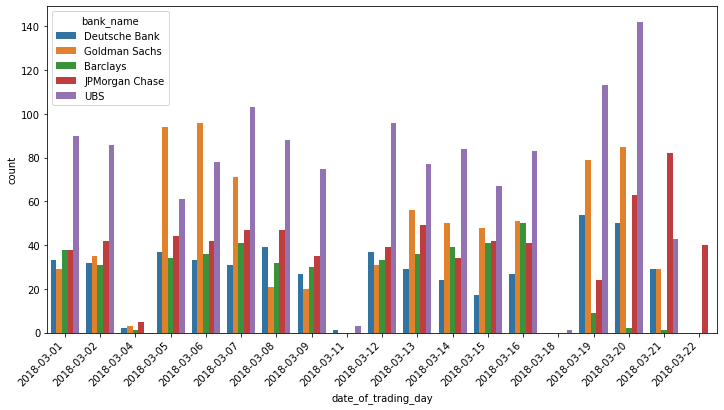

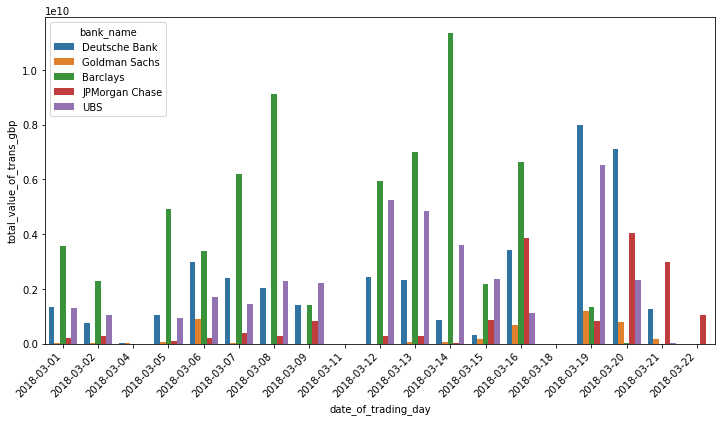

In [151]:
import seaborn as sns
import matplotlib.pyplot as plt

banks = df['bank_name'].unique()
dates = df.groupby('date_of_trading_day')


#print(df.groupby('bank_name').head(10))
#print(banks.agg(['count']))

# Set the width and height of the figure
#plt.figure(figsize=(30,6))
#print(dates.agg(['count']))

b=df.groupby('bank_name').get_group('Barclays')
d=df.groupby('bank_name').get_group('Deutsche Bank')
fig, ax = plt.subplots(figsize = (12,6)) 
#sns.barplot(x = df['date_of_trading_day'], y = df['total_value_of_trans_eur'], estimator = sum, ci = None, ax=ax, hue = df['bank_name'])

sns.countplot(x = df['date_of_trading_day'], ax=ax, hue = df['bank_name'])

x_dates = df['date_of_trading_day'] .dt.strftime('%Y-%m-%d').sort_values().unique()
ax.set_xticklabels(labels=x_dates, rotation=45, ha='right')

#new graph - showing off the total value of gbp traded
volume = df.groupby('total_value_of_trans_gbp')
fig, ax = plt.subplots(figsize = (12,6))
sns.barplot(x = df['date_of_trading_day'], y = df['total_value_of_trans_gbp'], estimator = sum, ci = None ,ax=ax, hue = df['bank_name'])
x_dates = df['date_of_trading_day'] .dt.strftime('%Y-%m-%d').sort_values().unique()
ax.set_xticklabels(labels=x_dates, rotation=45, ha='right')


#new graph - showing off a single banks IMM roll activity


In [122]:
import unittest
import os

TESTDATA_FILENAME = 'C:/Users/inald/Documents/NWMprod/wetransfer-0f4d76/rts27.feather'
dfTest = pd.read_feather('C:/Users/inald/Documents/NWMprod/wetransfer-0f4d76/rts27.feather')

class TestNotebook(unittest.TestCase):
    
    
    def test_add(self):
        self.assertEqual(4,4)

    #checks that the dataframes contain frames
    def test_data_read(self):
        if dfTest.empty:
            self.assertTrue(False)
        else:
            self.assertTrue(True)
    
    #Test to check that columns are disposed of that are not needed        
    def test_dropping_columns(self):
        dropped_df = dfTest.drop(['date_created', 'instrument_identifier'], axis=1)
        Xtest = dropped_df
        count = 0
        count2 = 0
        for col in dfTest.columns:
            count = count + 1
        for col in Xtest.columns:
            count2 = count + 1
        self.assertNotEqual(count, count2)
        
   #Test to check that the train data is larger than the test - test the 80% v 20% difference    
    def test_splitting_data_size(self):
        Xtest = dfTest.drop(['date_created', 'instrument_identifier'], axis=1)
        ytest = dfTest['date_created']
        Xtest_train, Xtest_valid, ytest_train, ytest_valid = train_test_split(Xtest, ytest, train_size=0.8, test_size=0.2, random_state=0)
        if Xtest_train.size > Xtest_valid.size:
            self.assertTrue(True)
        else:
            self.assertTrue(False)
    
    unittest.main(argv=[''], verbosity=3, exit=False)
   

test_add (__main__.TestNotebook) ... ok
test_data_read (__main__.TestNotebook) ... ok
test_dropping_columns (__main__.TestNotebook) ... ok
test_splitting_data_size (__main__.TestNotebook) ... ok

----------------------------------------------------------------------
Ran 4 tests in 330.852s

OK
